In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Bengali Handwritten Character recognition
For the recognition of Bengali handwritten characters, I have utilized the Banglalekha-Isolated dataset, which comprises 84 classes. These classes include 50 basic characters, 10 numerals, and 24 compound characters. In this notebook, the MobileNetV2 model is implemented alongside the Convolutional Block Attention Module (CBAM) to enhance performance.

In [2]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import cv2
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from torch.utils.data import DataLoader,Dataset
from tqdm.notebook import trange
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

2024-07-07 16:07:17.896065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 16:07:17.896183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 16:07:18.024786: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [4]:
import os
import shutil

import cv2
from tqdm import tqdm

input_path="../input/banglalekha-isolated/BanglaLekha-Isolated/Images/"
# Set the path where you want to create the temporary directory
base_path = '/kaggle/working/'

# Create a temporary directory
temp_dir= os.path.join(base_path, 'temp_directory')
os.makedirs(temp_dir, exist_ok=True)

# Create folders "01" to "12" inside the temporary directory

j=0
for i in range(1,85):
    folder_name = f'{j:02d}'  # Format the folder name with leading zeros
    
    folder_path = os.path.join(temp_dir, folder_name)
    j=j+1
    #os.makedirs(folder_path, exist_ok=True)
    pth=input_path+str(i)
    fold=os.listdir(pth)
    shutil.copytree(pth, folder_path)

In [5]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        # check the folders from main directory. If there are another files, ignore them
        

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    dummy_df, test_df = train_test_split(df,  train_size= 0.85, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    train_df,valid_df= train_test_split(dummy_df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [6]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (128,128)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar,zoom_range=0.2, width_shift_range = 0.1,
                                         height_shift_range = 0.1,rotation_range=15)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = tr_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [7]:
path="/kaggle/working/temp_directory"
train_df, valid_df, test_df = split_data(path)
batch_size = 32
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 112951 validated image filenames belonging to 84 classes.
Found 28238 validated image filenames belonging to 84 classes.
Found 24916 validated image filenames belonging to 84 classes.


# Implementation of Convolutional Block Attention Module(CBAM)


In [8]:
from keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Reshape, Bidirectional, LSTM, Dropout
from keras import regularizers
def channel_attention(input_tensor, reduction_ratio=16):
    num_channels = input_tensor.shape[-1]
    l1=tf.keras.layers.Dense(num_channels//reduction_ratio,activation='relu',use_bias=False)
    l2=tf.keras.layers.Dense(num_channels,use_bias=False)
    
    x1=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    x1=l1(x1)
    x1=l2(x1)
    
    x2=tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
    x2=l1(x2)
    x2=l2(x2)
    
    feats=x1+x2
    feats=Activation("sigmoid")(feats)
    feats=layers.Multiply()([input_tensor,feats])
    
    return feats
def spatial_attention(input_tensor):
    kernel_size = 7
    
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_tensor)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_tensor)
    concat = layers.Concatenate(axis=3)([avg_pool, max_pool])
    
    out = layers.Conv2D(1, kernel_size, padding='same', activation='sigmoid', kernel_initializer='he_normal')(concat)

    return layers.Multiply()([input_tensor, out])
def cbam_block(input_tensor, reduction_ratio=16):
    channel_att = channel_attention(input_tensor, reduction_ratio)
    spatial_att = spatial_attention(channel_att)
    
    return spatial_att

# mobileNetV2 model with CBAM

In [9]:
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2
base_model2 = MobileNetV2(include_top= False, weights= "imagenet", input_shape= (128,128,3))

base_model2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [10]:

for layer in base_model2.layers:
    layer.trainable=True
#base_model2.trainable=False

In [11]:
METRICS=[
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]


In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Assuming base_model2 is already defined and created
#x = base_model2.layers[-2].output
input_tensor = Input(shape=(128,128,3))  # Replace with your input shape
base_model_output = base_model2(input_tensor)
cbam_output = cbam_block(base_model_output)


x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(cbam_output)
x = Dropout(rate=0.25)(x)
x= tf.keras.layers.GlobalAveragePooling2D()(x)  # Flattening the output from the CBAM block
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output_tensor = Dense(84, activation='softmax')(x)

model2 = Model(inputs=input_tensor, outputs=output_tensor)
from tensorflow.keras.optimizers import Adam
model2.compile(optimizer=Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= METRICS)

model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_1… │ (None, 4, 4,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 80)        │    102,400 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1280)      │    102,400 │ dense[0][0],      │
│                     │                   │            │ dense[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1280)      │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1280)      │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 4, 4,      │          0 │ mobilenetv2_1.00… │
│                     │ 1280)             │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 4, 4, 1)   │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 4, 4, 1)   │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 4, 2)   │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 4, 4, 1)   │         99 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 4, 4,      │          0 │ multiply[0][0],   │
│ (Multiply)          │ 1280)             │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 4, 4,      │      5,120 │ multiply_1[0][0]  │
│ (BatchNormalizatio… │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4, 4,      │          0 │ batch_normalizat… │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ dropout[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    327,936 │ global_average_p

 Total params: 2,883,319 (11.00 MB)

 Trainable params: 2,846,647 (10.86 MB)

 Non-trainable params: 36,672 (143.25 KB)

In [13]:
history=model2.fit(train_gen, epochs=40, batch_size=32,  validation_data = (valid_gen))

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   1/3530 ━━━━━━━━━━━━━━━━━━━━ 55:03:09 56s/step - accuracy: 0.0000e+00 - loss: 4.5639 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1720369328.239383      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3530/3530 ━━━━━━━━━━━━━━━━━━━━ 779s 205ms/step - accuracy: 0.5720 - loss: 1.7916 - precision: 0.8646 - recall: 0.4506 - val_accuracy: 0.8654 - val_loss: 0.4812 - val_precision: 0.9053 - val_recall: 0.8385
Epoch 2/40
3530/3530 ━━━━━━━━━━━━━━━━━━━━ 739s 195ms/step - accuracy: 0.8841 - loss: 0.4100 - precision: 0.9227 - recall: 0.8562 - val_accuracy: 0.8933 - val_loss: 0.3836 - val_precision: 0.9243 - val_recall: 0.8761
Epoch 3/40
3530/3530 ━━━━━━━━━━━━━━━━━━━━ 686s 194ms/step - accuracy: 0.9046 - loss: 0.3363 - precision: 0.9338 - recall: 0.8850 - val_accuracy: 0.8935 - val_loss: 0.3933 - val_precision: 0.9251 - val_recall: 0.8753
Epoch 4/40
3530/3530 ━━━━━━━━━━━━━━━━━━━━ 686s 194ms/step - accuracy: 0.9118 - loss: 0.3045 - precision: 0.9362 - recall: 0.8944 - val_accuracy: 0.9079 - val_loss: 0.3336 - val_precision: 0.9292 - val_recall: 0.8958
Epoch 5/40
3530/3530 ━━━━━━━━━━━━━━━━━━━━ 685s 194ms/step - accuracy: 0.9186 - loss: 0.2807 - precision: 0.9414 - recall: 0.9043 - val_accuracy: 0.

In [14]:
test_auc,test_loss,test_precision,test_recall=model2.evaluate(test_gen)

6229/6229 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.9285 - loss: 0.3123 - precision: 0.9373 - recall: 0.9255


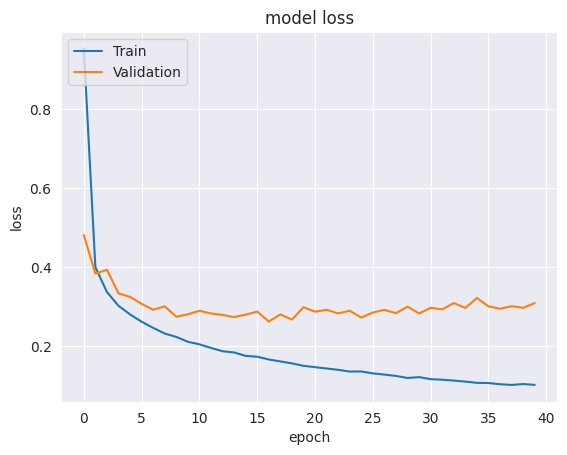

In [15]:


import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



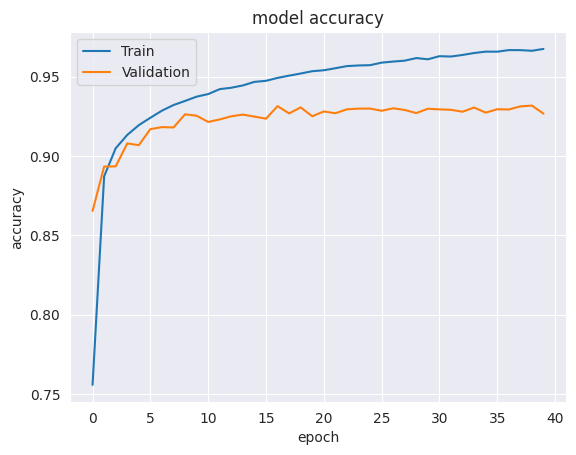

In [16]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()